In [1]:
!pip install -q flwr[simulation] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 KB 34.7 MB/s eta 0:00:00


In [2]:
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cpu using PyTorch 1.13.1+cu116 and Flower 1.3.0


## Data Preparation


In [3]:
# parameters
time_step = 48
BATCH_SIZE = 32

In [4]:
data = []
with open ('House_30.txt', 'r') as reader:
  for line in reader:
    stripped_line = line.strip().split()
    data.append(stripped_line)

tem = [x[0] for x in data]
houses = list(set(tem))

date = []
consumption = []
for i in houses:
  date.append([float(x[1]) for x in data if x[0]==i])
  consumption.append([float(x[2]) for x in data if x[0]==i])    

In [5]:
def create_label(data, time_step):
  x_nest, y_nest = [], []
  for j in range(len(data)):
    x_data, y_data = [], []
    for i in range(len(data[j]) - time_step):
      x = data[j][i: (i + time_step)]
      x_data.append(x)
      y = [data[j][i + time_step]]
      y_data.append(y)

    #x_data = np.array(x_data)[:, :, np.newaxis]
    x_data = np.array(x_data)[:, :]
    #x_data = np.array(x_data)[:, np.newaxis, :]
    x_nest.append(x_data)
    y_nest.append(y_data)
  x_nest = np.array(x_nest)
  y_nest = np.array(y_nest)
  return x_nest, y_nest
# 可能要去掉x的最后一个维度 从（48，1）变为（48）

In [6]:
input, labels = create_label(consumption, time_step)


In [7]:
input = np.float32(input)
labels = np.float32(labels)


### Create Dataset

In [8]:
# 定义GetLoader类，继承Dataset方法，并重写__getitem__()和__len__()方法
class GetLoader(torch.utils.data.Dataset):
	# 初始化函数，得到数据
    def __init__(self, data_root, data_label):
        self.data = data_root
        self.label = data_label
    # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
    def __getitem__(self, index):
        data = self.data[index]
        labels = self.label[index]
        return data, labels
    # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一脸懵逼
    def __len__(self):
        return len(self.data)


In [9]:
length = len(input[0])
val = int(0.7*length)
test = int(0.9*length)
trainloaders = []
valloaders = []
testloaders = []

def load_datasets(input, labels):

  Xtrain_raw = [x[0: val] for x in input]
  Xval_raw = [x[val: test] for x in input]
  Xtest_raw = [x[test: ] for x in input]

  Ytrain_raw = [x[0: val] for x in labels]
  Yval_raw = [x[val: test] for x in labels]
  Ytest_raw = [x[test: ] for x in labels]

  for i in range(30):
    ds_train = GetLoader(Xtrain_raw[i], Ytrain_raw[i])
    trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True))
    ds_val = GetLoader(Xval_raw[i], Yval_raw[i])
    valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE, drop_last=True))
    ds_test= GetLoader(Xtest_raw[i], Ytest_raw[i])
    testloaders.append(DataLoader(ds_test, batch_size=BATCH_SIZE, drop_last=True))

  return trainloaders, valloaders, testloaders




In [10]:
trainloaders, valloaders, testloaders = load_datasets(input, labels)

## Create Model

In [11]:
import torch.nn as nn


In [12]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(48, 48),
            act(),
            nn.Linear(48, 48),
            act(),
            nn.Linear(48, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.body(x)
        return out

criterion = nn.MSELoss() 
net = DNN().to(DEVICE)


In [13]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for x, y in trainloader:
            
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()

            #x = x.unsqueeze(0)
            outputs = net(x)
            loss = criterion(net(x), y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
           
        epoch_loss /= len(trainloader.dataset)
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}") 


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = nn.MSELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = net(x)
            loss += criterion(outputs, y).item()

    loss /= len(testloader.dataset)
   
    return loss 

### central test

In [14]:
x, y = next(iter(trainloaders[0]))

In [16]:
trainloader = trainloaders[0]
valloader = valloaders[0]
testloader = testloaders[0]

net = DNN().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}")

loss = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}")



Epoch 1: validation loss 0.00046161330305311883
Epoch 2: validation loss 0.0004643828129741099
Epoch 3: validation loss 0.0004597749009186611
Epoch 4: validation loss 0.0004479574013557256
Epoch 5: validation loss 0.00044634901808130167
Final test set performance:
	loss 0.0004570533737621482


## FL

In [17]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)



In [18]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(0)}



In [19]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = DNN().to(DEVICE)



    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [20]:
NUM_CLIENTS = 30

In [21]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.3,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
  client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10), #10
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-03-02 10:35:27,091 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-03-02 10:35:30,323	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-03-02 10:35:32,451 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7921739367.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3960869683.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7921739367.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3960869683.0}
INFO flwr 2023-03-02 10:35:32,461 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-02 10:35:32,468 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO flwr 2023-

History (loss, distributed):
	round 1: 0.0005071522247761447
	round 2: 0.000494309431758388
	round 3: 0.0004312967937400593
	round 4: 0.0005382926278649015
	round 5: 0.0006636932836009273
	round 6: 0.0006370644797949081
	round 7: 0.0005757896574412962
	round 8: 0.0006899634151506374
	round 9: 0.00039990288845295893
	round 10: 0.000741631588620531

In [22]:
net

DNN(
  (body): Sequential(
    (0): Linear(in_features=48, out_features=48, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=48, out_features=48, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=48, out_features=1, bias=True)
  )
)

In [23]:
x_t, y_t = next(iter(testloaders[0]))

In [24]:
pred = net(x_t)

In [28]:
pred = pred.detach().numpy()
y_t = y_t.detach().numpy()

In [25]:
def plot_series(time, series, format='-', start=0, end=None, label=None, color=None):
  plt.plot(time[start:end], series[start:end], format, label=label, color=color)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

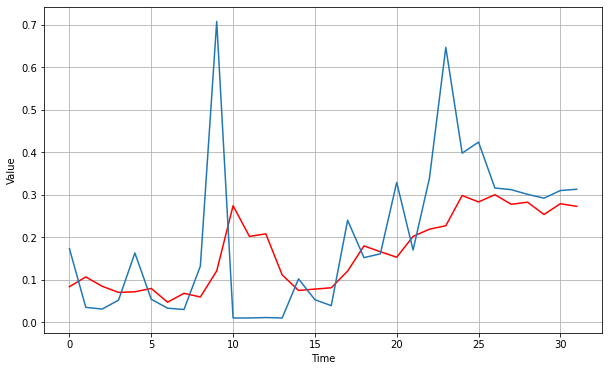

In [29]:
plt.figure(figsize=(10, 6))
time_plot = range(len(y_t))
plot_series(time_plot, pred, color='red')
plot_series(time_plot, y_t)